# COMP30027 Machine Learning Assignment 2

### Project 2: How long does it take to cook this? 
**Task:** Build a classifier to predict cooking time of recipes

**Author:** Tuan Khoi Nguyen - 1025294. 
Hai Hong Tran    - 1012919

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import os
import pandas as pd
import numpy as np
import re
import time

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectPercentile, SelectFpr, chi2, mutual_info_classif
from sklearn.model_selection import cross_val_score

from tqdm import tqdm,trange
from collections import defaultdict,Counter
from text2digits import text2digits

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Part 0: Data preprocessing method selection

In [49]:
def preprocess(file, 
               process = None, 
               convert_to_seconds = False):
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    if not process:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\'+file)
    else:
        train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_' + process + '\\' + file)

    data = pd.read_csv(train_file, index_col = False, delimiter = ',')
    if convert_to_seconds:
        tqdm.pandas(desc="Converting...")
        data['seconds'] = data['steps'].progress_apply(convert_step_to_time)
    return data

In [9]:
def read_npz_file(files_name, use_scipy = True):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\' , file_name))
    
    if use_scipy:
        names = scipy.sparse.load_npz(file_paths[0])
        ingr = scipy.sparse.load_npz(file_paths[1])
        steps = scipy.sparse.load_npz(file_paths[2])
        return names, ingr, steps
    
    npz_names = np.load(file_paths[0])
    names = pd.DataFrame.from_dict({i: npz_names[i] for i in npz_names.files}, orient='index')

    npz_ingr = np.load(file_paths[1])
    ingr = pd.DataFrame.from_dict({i: npz_ingr[i] for i in npz_ingr.files}, orient='index')

    npz_steps = np.load(file_paths[2])
    steps = pd.DataFrame.from_dict({i: npz_steps[i] for i in npz_steps.files}, orient='index')
    return names,ingr,steps

def read_train_file(preprocess_method, files_name):
    file_paths = []
    for file_name in files_name:
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        file_paths.append(os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\', preprocess_method, file_name))
    
    names = pd.read_csv(file_paths[0], index_col = False, delimiter = ',', header=None)
    ingr = pd.read_csv(file_paths[1], index_col = False, delimiter = ',', header=None)
    steps = pd.read_csv(file_paths[2], index_col = False, delimiter = ',', header=None)
    
    return names, ingr, steps

In [48]:
time_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        [n + w + "\\b" for w in words for n in ["[0-9]+\s*","another ","few ","a ","an ","several "]])), sentence)

kw_retrieval = lambda words, sentence : re.findall(re.compile('|'.join(
        ["\\b" + w + "\\b" for w in words])), sentence)

def convert_step_to_time(step, keyword_check = True):
    t2d = text2digits.Text2Digits()
    total_time = 0 # in seconds
    times = defaultdict(list)
    time_unit = {"second":1, "minute":60, "hour":60*60}
    kw_dict = {"overnight":8, "night":8, "nights":8, "freeze":5, "refrigerate":3,
               "day":12, "cook on low":7, "slow cook":7, "crockpot":7, "crock pot":7,
               "cook low":7, "boil":1, "heat":1, "bread machine":1.5
               }
    
    # Iterate through each step to find time value using RE
    numeric_step = t2d.convert(step)
    times["second"] = time_retrieval(["more seconds","more second","more secs","more sec","seconds","second","secs","sec","s"],numeric_step)
    times["minute"] = time_retrieval(["more minutes","more minute","more min","more mins","minutes","minute","min","mins","m","ms"],numeric_step)
    times["hour"] = time_retrieval(["more hours","more hour","more hrs","more hr","hours","hour","hrs","hr","h","hs"],numeric_step)
    special_keywords = kw_retrieval(kw_dict.keys(),numeric_step) if keyword_check else None

    for unit in time_unit.keys():
        #total_time += sum([float(re.findall(r'[0-9]+',t.split()[0])[0]) * time_unit[unit] for t in times[unit]])
        count = 0
        for t in times[unit]:
            numerator = t.split()[0]

            if numerator in ["another","a","an"]:
                count = 1
            elif numerator in ["few","several"]:
                count = 4
            else:
                count = float(re.findall(r'[0-9]+',numerator)[0])

            total_time += count * time_unit[unit]

    if keyword_check and not total_time and special_keywords:
        total_time += 60*60*kw_dict[special_keywords[0]]

    if total_time == 0:
        return None
    return total_time

In [36]:
kw_dict = {"overnight":8, "night":8, "nights":8, "refrigerate":4,
            "day":12, "freeze":6, "cook on low":7, "slow cook":7,
            "cook low":7, "bread machine":7, "boil":1, "heat":1.5}
kw_retrieval(kw_dict.keys(),'freeze overnight then put to boil')   
kw_dict.values()         

dict_values([8, 8, 8, 4, 12, 6, 7, 7, 7, 7, 1, 1.5])

### Read given preprocessed text input

Run each code cell below for specified file to be read

**Count vectorizer**

In [33]:
name, ingr, steps = read_npz_file(['train_name_vec.npz', 'train_ingr_vec.npz', 'train_steps_vec.npz'])
#print(steps)
steps[((0,584))]

1

In [28]:
npz = np.load('COMP30027_2021_Project2_datasets\\recipe_text_features_countvec\\train_steps_vec.npz')
print(npz.files)
npz['format']
pd.DataFrame.from_dict({i: npz[i] for i in ['indices', 'indptr', 'data']})

['indices', 'indptr', 'format', 'shape', 'data']


,0,1,2,3,4,5,6,7,8,9,...,1737811,1737812,1737813,1737814,1737815,1737816,1737817,1737818,1737819,1737820
indices,584,1172,2473.0,2726.0,2783.0,3248.0,3354.0,3554.0,4007.0,4442.0,...,12331.0,13008.0,13626.0,13636.0,14293.0,14582.0,15176.0,15265.0,16105.0,16107.0
indptr,0,30,71.0,123.0,162.0,184.0,239.0,273.0,364.0,388.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shape,40000,17967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
data,1,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [29]:
Counter(npz['data'])

Counter({1: 1398228,
         3: 63583,
         2: 238407,
         4: 22181,
         6: 3528,
         5: 8498,
         10: 186,
         15: 20,
         7: 1620,
         8: 821,
         9: 421,
         11: 114,
         12: 92,
         18: 7,
         14: 37,
         24: 3,
         13: 41,
         20: 2,
         19: 3,
         17: 5,
         22: 2,
         16: 7,
         21: 2,
         29: 1,
         39: 1,
         25: 1,
         30: 1,
         188: 1,
         28: 5,
         35: 1,
         32: 1,
         23: 1})

**doc2vec50**

In [105]:
files_name = ['train_name_doc2vec50.csv', 'train_ingr_doc2vec50.csv', 'train_steps_doc2vec50.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec50\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.13164758682250977
GNB Accuracy: 0.5792750000000001 	Runtime: 0.658240795135498
LinearSVC Accuracy: 0.5933 	Runtime: 121.30808925628662
Decision Tree Accuracy: 0.4963 	Runtime: 32.94474005699158
KNN Accuracy: 0.5768500000000001 	Runtime: 38.69227933883667
Logistic Regression Accuracy: 0.59415 	Runtime: 8.293499231338501

Evaluating on Ingredient Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.15262579917907715
GNB Accuracy: 0.5492 	Runtime: 0.6073424816131592


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC Accuracy: 0.57775 	Runtime: 212.75199437141418
Decision Tree Accuracy: 0.50135 	Runtime: 36.771679401397705
KNN Accuracy: 0.554625 	Runtime: 38.07138729095459
Logistic Regression Accuracy: 0.5777499999999999 	Runtime: 9.737960577011108

Evaluating on Steps Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.14165735244750977
GNB Accuracy: 0.6214999999999999 	Runtime: 0.6163501739501953


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.647825 	Runtime: 255.95509934425354
Decision Tree Accuracy: 0.5536749999999999 	Runtime: 37.71866059303284
KNN Accuracy: 0.631075 	Runtime: 31.842905521392822
Logistic Regression Accuracy: 0.6511 	Runtime: 11.986218214035034



**doc2vec100**

In [103]:
files_name = ['train_name_doc2vec100.csv', 'train_ingr_doc2vec100.csv', 'train_steps_doc2vec100.csv']
name, ingr, steps = read_train_file('recipe_text_features_doc2vec100\\', files_name)

X = [name, ingr, steps]
i = 0
for x in X:
    if i == 0:
        print('Evaluating on Name Feature:')
    elif i == 1:
        print('Evaluating on Ingredient Feature:')
    else:
        print('Evaluating on Steps Feature:')
        
    models = [DummyClassifier(strategy='most_frequent'),
              GaussianNB(),
              LinearSVC(),
              DecisionTreeClassifier(),
              KNeighborsClassifier(),
              LogisticRegression()]

    titles = ['Zero-R',
              'GNB',
              'LinearSVC',
              'Decision Tree',
              'KNN',
              'Logistic Regression']

    for title, model in zip(titles, models):
        start = time.time()
        acc = np.mean(cross_val_score(model, x, y, cv=10))
        end = time.time()
        t = end - start
        print(title, "Accuracy:",acc, '\tRuntime:', t)
    print()
    i = i + 1

Evaluating on Name Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.3071775436401367
GNB Accuracy: 0.5730749999999999 	Runtime: 1.132969617843628
LinearSVC Accuracy: 0.607325 	Runtime: 188.9464361667633
Decision Tree Accuracy: 0.492225 	Runtime: 64.57338762283325
KNN Accuracy: 0.576975 	Runtime: 41.29353332519531


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6096000000000001 	Runtime: 19.49396586418152

Evaluating on Ingredient Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.34408068656921387
GNB Accuracy: 0.54725 	Runtime: 1.42818284034729


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.58235 	Runtime: 423.3654956817627
Decision Tree Accuracy: 0.49355000000000004 	Runtime: 73.16237497329712
KNN Accuracy: 0.5379500000000002 	Runtime: 40.18614101409912
Logistic Regression Accuracy: 0.5824499999999999 	Runtime: 16.332329750061035

Evaluating on Steps Feature:
Zero-R Accuracy: 0.5061500000000001 	Runtime: 0.28224611282348633
GNB Accuracy: 0.603275 	Runtime: 1.347395896911621


c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\python38\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
c:\py

LinearSVC Accuracy: 0.6658000000000001 	Runtime: 424.7097158432007
Decision Tree Accuracy: 0.53675 	Runtime: 76.39373779296875
KNN Accuracy: 0.57255 	Runtime: 35.4543981552124


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

Logistic Regression Accuracy: 0.6700000000000002 	Runtime: 18.288459539413452



### Creative text preprocessing method
Idea: Find all time-related content in 'steps' feature using Regular Expression. Sum the times up for total time and use that as a feature in training and classifying

In [196]:
# test function
#convert_step_to_time('3hrs and 10 hrs and 3 hours')
#re.findall(r"[0-9]+\s*hours\b|[0-9]+\s*hrs\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(r"[0-9]+\s*hours\b|[0-9]+\s*hour\b|[0-9]+\s*hrs\b|[0-9]+\s*hr\b|[0-9]+\s*h\b|[0-9]+\s*hs\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(r"[0-9]+\s*s[(ec+)\s\,\;\.]",'1s and 20 sec and 3sec and 4 sex and 5se and 6s, and 7se.')
#re.findall(r"s(ec+)",'1s and 20 sec and 3sec and 4 sex and 5se and 6s, and 7se.')
#re.findall(r"[0-9]+\s*"+"hours\b",'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
#re.findall(re.compile(''.join(["[0-9]", "\s*", "house"])), "1 house,2house")
#re.findall(re.compile('|'.join(["[0-9]+\s*" + word + "\\b" for word in ["hours","hour","hrs","hr","h"]])), '1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')
time_retrieval(["hours","hour","hrs","hr","h"],'1hrs and 20 hrs and 3 hours and 4 halves and 5h and 6h, and 7h. 8house')

['1hrs', '20 hrs', '3 hours', '5h', '6h', '7h']

In [53]:
data = preprocess('recipe_train.csv', convert_to_seconds=True)
data.sample(20)

Converting...: 100%|██████████| 40000/40000 [01:26<00:00, 463.56it/s]


,name,n_steps,n_ingredients,steps,ingredients,duration_label,seconds
32447,ww honey glazed salmon with wasabi 4 points,10,10,"['to make the sauce , bring the mirin , vinega...","['rice wine', 'seasoned rice vinegar', 'reduce...",1.0,540.0
31526,caramel apple and pear crisp,15,11,"['heat oven to 375f', 'spray 8-inch square bak...","['apples', 'pears', 'sugar', 'allspice', 'cara...",2.0,3000.0
39588,roasted root vegetables,8,8,"['heat oven to 400 degrees', 'place the root v...","['vegetables', 'onion', 'olive oil', 'salt', '...",2.0,6600.0
26226,thanksgiving rolls,5,6,"['mix together the first 5 ingredients', 'unro...","['sour cream', 'onion', 'celery salt', 'parsle...",1.0,NaN
22098,creamy clam chowder,9,9,"['in a medium skillet over medium heat , cook ...","['bacon', 'celery', 'onion', 'butter', 'flour'...",2.0,1800.0
24348,breakfast cream cheese snack cake,10,12,"['in a medium mixing bowl , cream butter with ...","['butter', 'cream cheese', 'eggs', 'sugar', 'v...",2.0,1800.0
17621,spinach asparagus salad with strawberry dressing,6,9,"['make dressing: combine strawberries , juice ...","['strawberry', 'orange juice', 'raspberry vine...",1.0,10800.0
6717,mean chef s apple rustic tarts,18,7,['for the streusel: in a food processor fitted...,"['unbleached all-purpose flour', 'granulated s...",2.0,9000.0
12541,buckwheat pilaf,8,11,['place water or stock in a 3 quart pot and br...,"['buckwheat groats', 'water', 'toasted sesame ...",2.0,1380.0
8547,roasted potato salad with bacon,19,11,"['heat the oven to 375f', 'clean and halve fin...","['potatoes', 'garlic', 'olive oil', 'kosher sa...",2.0,11700.0


In [54]:
test_data = preprocess('recipe_test.csv', convert_to_seconds=True)
test_data.sample(20)

Converting...: 100%|██████████| 10000/10000 [00:21<00:00, 473.43it/s]


,name,n_steps,n_ingredients,steps,ingredients,seconds
8561,hill country cocoa pecan pie,22,10,"['preheat oven to 350 degrees', 'lightly greas...","['all-purpose flour', 'butter', 'salt', 'water...",5700.0
8576,slow simmered spaghetti sauce,3,9,['combine all ingredients in a 4-quart slow co...,"['garlic', 'onion', 'italian-style tomatoes', ...",21600.0
7136,vietnamese lemon rice,6,6,"['wash rice until water runs clear , then drai...","['jasmine rice', 'water', 'salt', 'olive oil',...",1200.0
1388,beef curry pillows,24,12,"['brown the ground beef with the onion', 'remo...","['ground beef', 'white onion', 'green curry pa...",3600.0
5849,hazelnut shortbread buttons,13,5,['toast the hazelnuts in a 180c oven for 5 min...,"['butter', 'icing sugar', 'cornflour', 'flour'...",2100.0
4690,kellys lime chiffon cheesecake dessert,12,10,"['mix crust ingredients , save aside 2 tablesp...","['graham cracker crumbs', 'sugar', 'butter', '...",10800.0
3181,coconut creamed rice microwave,7,7,['place rice in a colander & wash under cold w...,"['arborio rice', 'coconut milk', 'water', 'uns...",1740.0
496,quick chicken kebabs,11,9,"['put chicken , onions , garlic , chillies , b...","['chicken breasts', 'onions', 'dried garlic', ...",3600.0
2994,butter crunch squares,13,6,['grease a 12 by 17 inch cookie sheet with sid...,"['unsalted saltine crackers', 'butter', 'light...",1680.0
2726,cobbed corn with kick,6,5,"['place corn , peppers and onion in deep dish ...","['italian salad dressing', 'ears of corn', 're...",3300.0


In [55]:
print(np.mean(data.loc[data['duration_label']==1.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==2.0]['seconds']))
print(np.mean(data.loc[data['duration_label']==3.0]['seconds']))
data['steps'].iloc[39995]

3868.6148775189154
4546.9969594080985
28783.782587309393


'[\'in a measuring cup , combine sour cream and lemon juice\', \'add enough of the milk to make 1 / 2 cup\', "place all bread ingredients in bread machine according to your manufacturer\'s directions", \'select sweet bread or basic setting\', \'do not use timer delay for this recipe\', \'for spread , beat all ingredients together until smooth\']'

In [109]:
# Evaluate this new feature
train_data = data.loc[:,['n_steps','n_ingredients','seconds','steps','duration_label']]

# Why is the time missing?
missing_time_data = train_data.loc[np.isnan(train_data['seconds'])]
print(Counter(missing_time_data['duration_label']))

# How did the steps for different lengths look like, given that no timing is found?
long_missing = missing_time_data.loc[missing_time_data['duration_label']==3, ['steps']]
#long_missing.head(10)
[[print(s) for s in long_missing.iloc[i]] for i in range(10)]

Counter({1.0: 4356, 2.0: 513, 3.0: 16})
['cook on light cycle in your bread maker machine']
['for the artichoke hearts i have used either the jarred marinated or frozen hearts-thawed', 'make the cocktail dressing first by combining the mayonnaise , chili sauce , parsley , worcestershire , and black pepper', 'cover and chill', 'cut grapefruits in half', 'remove the fruit segments with a serrated spoon', 'cut the fruit segments up into bite sized pieces and toss with the lemon juice', 'clean out the grapefruit shells and remove pith', 'set aside', 'in a bowl gently mix the grapefruit , shrimp , cayenne and rum', 'cut the marinated artichokes up into bite sized pieces and combine with the grapefruit / shrimp mixture', 'if using frozen artichoke hearts , squeeze out the excess moisture gently with your hands', 'divide the mixture and spoon into the grapefruit shells', 'divide and spoon the cocktail dressing on top of each grapefruit shell', 'garnish with lemon slices and fresh parsley', 's

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

In [57]:
# We'll fix it later. For now, let's try and predict with the existing values first
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer


train_data = data.loc[np.isnan(data['seconds']) == False,['n_steps','n_ingredients','seconds','duration_label']]
Xseconds = data.loc[np.isnan(data['seconds']) == False,['seconds']]
X=train_data.iloc[:,:-1]
Y=train_data.iloc[:,-1]

#imp = IterativeImputer(max_iter=10, random_state=0)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X)

test_data = preprocess('recipe_test.csv', convert_to_seconds=True)
X_test = test_data.reindex(columns=['n_steps','n_ingredients','seconds'])
X_test = imp.transform(X_test)
# Y_test = clf.predict(X_test)

# out = pd.DataFrame({'duration_label':Y_test})
# out.index += 1
# out.to_csv('output/output.csv',index_label = 'id')

models = [DummyClassifier(strategy='most_frequent'),
            GaussianNB(),
            LinearSVC(),
            DecisionTreeClassifier(),
            KNeighborsClassifier(),
            LogisticRegression()]

titles = ['0r',
          'nb',
          'LinearSVC',
          'decision_tree',
          'knn',
          'logistic_regression']

for title, model in zip(titles, models):
    model.fit(X,Y)
    Y_test = model.predict(X_test)
    out = pd.DataFrame({'duration_label':Y_test})
    out.index += 1
    out.to_csv('output/out_'+title+'.csv',index_label = 'id')

Converting...: 100%|██████████| 10000/10000 [00:23<00:00, 418.80it/s]
C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\HP OMEN 15\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Data visualization

<AxesSubplot:xlabel='n_steps', ylabel='n_ingredients'>

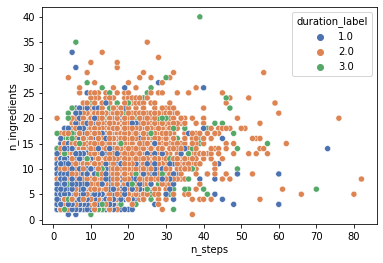

In [80]:
curr_dir = os.path.dirname(os.path.realpath('__file__'))
train_file = os.path.join(curr_dir, 'COMP30027_2021_Project2_datasets\\recipe_train.csv')

data = pd.read_csv(train_file, index_col = False, delimiter = ',')

numeric_data = data[['n_steps', 'n_ingredients', 'duration_label']]

y = data['duration_label']

sns.scatterplot(data=numeric_data, x="n_steps", y="n_ingredients", hue="duration_label", palette="deep")

## Part 1: Single model training and evaluation

## Part 2: Classifier combination training and evaluation